In [1]:
import mdtraj as md
import numpy as np
import pickle
import os
from tqdm import tqdm_notebook
from simtk.openmm import app
from simtk.openmm import unit
import matplotlib.pyplot as plt
from openeye import oechem

## Load htf for analysis (with water sampling)

In [5]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/18/8"
outdir_rest = "/data/chodera/zhangi/perses_benchmark/neq/17/8"
i = 8
phase = 'complex'
cycle = 0


In [6]:
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))


In [17]:
def new_positions(hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]
    
def old_positions(hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def make_traj(outdir, htf, i, phase, name, endstate, is_old=True, keep_solvent=False):
    with open(os.path.join(outdir, f"{i}_{phase}_{name}_1ns_snapshots.npy"), "rb") as f:
        cache = np.load(f)
    if is_old:
        old_pos = np.zeros(shape=(100, htf._topology_proposal.old_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            old_pos[j] = old_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))
    else:
        new_pos = np.zeros(shape=(100, htf._topology_proposal.new_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            new_pos[j] = new_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))
        
    box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
    vectors = np.array([box_vectors]) 
           
    # Set unit cell vectors in traj 
    traj.unitcell_vectors = np.repeat(vectors, 100, axis=0)
    traj = traj.image_molecules()
    
    if not keep_solvent:
        traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       
def make_traj_neq(outdir, htf, i, phase, cycle, is_old=True, is_forward=True):
    
    
    if is_old:
        
        modeller = app.Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
        modeller.deleteWater()
        
        if is_forward:
            with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_forward_neq_old.npy"), 'rb') as f:
                neq_old = np.load(f)
        else:
            with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_reverse_neq_old.npy"), 'rb') as f:
                neq_old = np.load(f)
        
        traj = md.Trajectory(neq_old, md.Topology.from_openmm(modeller.topology))
    else:
        modeller = app.Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
        modeller.deleteWater()
        
        if is_forward:
            with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_forward_neq_new.npy"), 'rb') as f:
                neq_new = np.load(f)
        else:
            with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_reverse_neq_new.npy"), 'rb') as f:
                neq_new = np.load(f)

        traj = md.Trajectory(neq_new, md.Topology.from_openmm(modeller.topology))
        
    box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
    vectors = np.array([box_vectors]) 
           
    # Set unit cell vectors in traj 
    traj.unitcell_vectors = np.repeat(vectors, 100, axis=0)
    traj = traj.image_molecules()
    
    return traj

In [11]:
with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_forward_neq_old.npy"), 'rb') as f:
    neq_old = np.load(f)

In [14]:
neq_old

array([[[1.3483977 , 5.06629   , 2.565294  ],
        [1.3938786 , 4.9730206 , 2.458738  ],
        [1.3289095 , 4.954185  , 2.3562167 ],
        ...,
        [5.661161  , 2.3643088 , 1.8477144 ],
        [2.9962046 , 5.0894995 , 5.071582  ],
        [4.1819234 , 6.2952623 , 5.050567  ]],

       [[1.4956465 , 4.8297987 , 2.7834394 ],
        [1.5173601 , 4.775613  , 2.6451995 ],
        [1.4397361 , 4.808201  , 2.5536914 ],
        ...,
        [5.463463  , 2.3908806 , 1.6998812 ],
        [3.0489366 , 4.9627194 , 4.9502535 ],
        [3.9743488 , 6.009955  , 4.8637657 ]],

       [[1.2933247 , 4.802126  , 2.6962273 ],
        [1.3800856 , 4.7461953 , 2.579412  ],
        [1.3608025 , 4.786241  , 2.4693623 ],
        ...,
        [5.503054  , 2.5092266 , 1.6702946 ],
        [2.9817858 , 4.947144  , 4.7845807 ],
        [4.3477516 , 6.2282906 , 4.712713  ]],

       ...,

       [[1.9480175 , 4.9454603 , 3.550856  ],
        [1.9828912 , 4.9181685 , 3.4071913 ],
        [1.9218078 , 4

In [12]:
neq_old.shape

(100, 3170, 3)

In [13]:
modeller = app.Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
modeller.deleteWater()
modeller.topology.getNumAtoms()

3170

## Check number of waters within 5 angstroms of K27A (REST)

K27

In [41]:
name = "lys"
endstate = 0
is_old = True
traj_rest_solvent = make_traj(outdir_rest, htf, i, phase, name, endstate, is_old, keep_solvent=True)


<ipython-input-25-45ff68d441e7>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [42]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 27 and atom.residue.name == 'LYS':
        print(atom, atom.residue.resSeq, atom.index)
        tyr_atoms.append(atom.index)

LYS27-N 27 390
LYS27-CA 27 391
LYS27-C 27 392
LYS27-O 27 393
LYS27-CB 27 394
LYS27-CG 27 395
LYS27-CD 27 396
LYS27-CE 27 397
LYS27-NZ 27 398
LYS27-H 27 399
LYS27-HA 27 400
LYS27-HB3 27 401
LYS27-HB2 27 402
LYS27-HG3 27 403
LYS27-HG2 27 404
LYS27-HD3 27 405
LYS27-HD2 27 406
LYS27-HE3 27 407
LYS27-HE2 27 408
LYS27-HZ3 27 409
LYS27-HZ1 27 410
LYS27-HZ2 27 411


In [43]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")


In [44]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)


(0.0, 18.0)

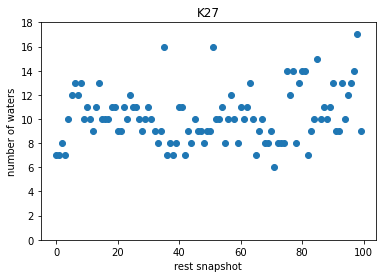

In [49]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("K27")
plt.ylim([0, 18])

In [50]:
from pymbar import timeseries

In [51]:
k27_waters = [len(frame) for frame in neighbors]


In [52]:
timeseries.statisticalInefficiency(k27_waters)


2.1320609944034388

A27

In [53]:
name = "ala"
endstate = 1
is_old = False
traj_rest_solvent_old = make_traj(outdir_rest, htf, i, phase, name, endstate, is_old, keep_solvent=True)

<ipython-input-25-45ff68d441e7>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [54]:
ala_atoms = []
for atom in traj_rest_solvent_old.topology.atoms:
    if atom.residue.resSeq == 27 and atom.residue.name == 'ALA':
        print(atom, atom.residue.resSeq, atom.index)
        ala_atoms.append(atom.index)

ALA27-N 27 390
ALA27-CA 27 391
ALA27-C 27 392
ALA27-O 27 393
ALA27-CB 27 394
ALA27-H 27 395
ALA27-HA 27 396
ALA27-HB3 27 397
ALA27-HB2 27 398
ALA27-HB1 27 399


In [55]:
water_atoms = traj_rest_solvent_old.topology.select("water and symbol == 'O'")


In [56]:
neighbors = md.compute_neighbors(traj_rest_solvent_old, 0.5, ala_atoms, haystack_indices=water_atoms)

(0.0, 18.0)

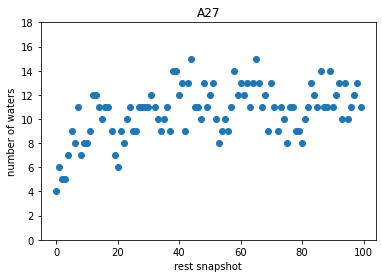

In [57]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("A27")
plt.ylim([0, 18])

In [58]:
a27_waters = [len(frame) for frame in neighbors]

In [59]:
timeseries.statisticalInefficiency(a27_waters)


5.614603696444751

## Check number of waters within 5 angstroms of K27A (neq)

NOTE cannot actually check this, as i didn't save the solvent positions during neq

K27

In [18]:
cycle = 20
is_old = True
is_forward=True
traj_rest_solvent = make_traj_neq(outdir, htf, i, phase, cycle, is_old, is_forward)


In [19]:
tyr_atoms = []
for atom in traj_rest_solvent.topology.atoms:
    if atom.residue.resSeq == 27 and atom.residue.name == 'LYS':
        print(atom, atom.residue.resSeq, atom.index)
        tyr_atoms.append(atom.index)

LYS27-N 27 390
LYS27-CA 27 391
LYS27-C 27 392
LYS27-O 27 393
LYS27-CB 27 394
LYS27-CG 27 395
LYS27-CD 27 396
LYS27-CE 27 397
LYS27-NZ 27 398
LYS27-H 27 399
LYS27-HA 27 400
LYS27-HB3 27 401
LYS27-HB2 27 402
LYS27-HG3 27 403
LYS27-HG2 27 404
LYS27-HD3 27 405
LYS27-HD2 27 406
LYS27-HE3 27 407
LYS27-HE2 27 408
LYS27-HZ3 27 409
LYS27-HZ1 27 410
LYS27-HZ2 27 411


In [20]:
water_atoms = traj_rest_solvent.topology.select("water and symbol == 'O'")


In [21]:
neighbors = md.compute_neighbors(traj_rest_solvent, 0.5, tyr_atoms, haystack_indices=water_atoms)


(0.0, 18.0)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

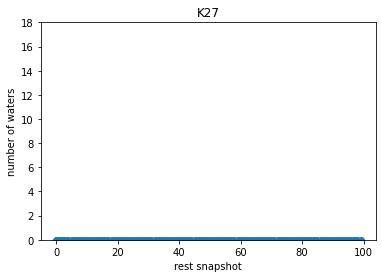

In [22]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("K27")
plt.ylim([0, 18])

In [23]:
from pymbar import timeseries

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [51]:
k27_waters = [len(frame) for frame in neighbors]


In [52]:
timeseries.statisticalInefficiency(k27_waters)


2.1320609944034388

A27

In [53]:
name = "ala"
endstate = 1
is_old = False
traj_rest_solvent_old = make_traj(outdir_rest, htf, i, phase, name, endstate, is_old, keep_solvent=True)

<ipython-input-25-45ff68d441e7>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j, pos in tqdm_notebook(enumerate(cache)):


0it [00:00, ?it/s]

ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

Exception ignored in: 'mdtraj.geometry._geometry.image_frame'
Traceback (most recent call last):
  File "/home/zhangi/miniconda3/envs/perses-rest2v2/lib/python3.8/site-packages/mdtraj/core/trajectory.py", line 2005, in image_molecules
    _geometry.image_molecules(result.xyz, box, anchor_molecules_atom_indices, other_molecules_atom_indices, sorted_bonds)
ValueError: Buffer dtype mismatch, expected 'float' but got 'double'


In [54]:
ala_atoms = []
for atom in traj_rest_solvent_old.topology.atoms:
    if atom.residue.resSeq == 27 and atom.residue.name == 'ALA':
        print(atom, atom.residue.resSeq, atom.index)
        ala_atoms.append(atom.index)

ALA27-N 27 390
ALA27-CA 27 391
ALA27-C 27 392
ALA27-O 27 393
ALA27-CB 27 394
ALA27-H 27 395
ALA27-HA 27 396
ALA27-HB3 27 397
ALA27-HB2 27 398
ALA27-HB1 27 399


In [55]:
water_atoms = traj_rest_solvent_old.topology.select("water and symbol == 'O'")


In [56]:
neighbors = md.compute_neighbors(traj_rest_solvent_old, 0.5, ala_atoms, haystack_indices=water_atoms)

(0.0, 18.0)

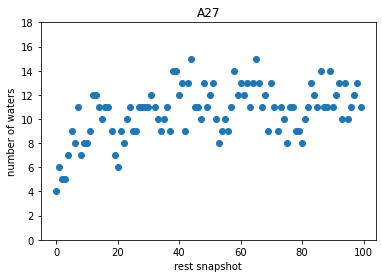

In [57]:
plt.scatter(range(len(neighbors)), [len(frame) for frame in neighbors])
plt.ylabel("number of waters")
plt.xlabel("rest snapshot")
plt.title("A27")
plt.ylim([0, 18])

In [58]:
a27_waters = [len(frame) for frame in neighbors]

In [59]:
timeseries.statisticalInefficiency(a27_waters)


5.614603696444751